In [29]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_dir = '../data/'

In [30]:
# collect data from csv
food_inflation_data = pd.read_csv(data_dir+'OCED_USA_FOOD_DATA.csv')
print(food_inflation_data.head(2))

  LOCATION INDICATOR SUBJECT MEASURE FREQUENCY     TIME     Value  Flag Codes
0      USA       CPI    FOOD  AGRWTH         M  1956-01 -1.700680         NaN
1      USA       CPI    FOOD  AGRWTH         M  1956-02 -2.372881         NaN


In [31]:
# plot the food inflation data with time vs inflation
# keep only the USA data
food_inflation_data_USA = food_inflation_data[food_inflation_data['LOCATION'] == 'USA']

time = food_inflation_data_USA['TIME']
time = pd.to_datetime(time)

inflation = food_inflation_data_USA['Value']

# make a new dataframe with only the USA inflation data
USA_inflation_timeseries = pd.DataFrame({'Date': time, 'CPI': inflation})
cpi_timeseries = USA_inflation_timeseries.set_index('Date').copy()
print(USA_inflation_timeseries.head(10))

# split the data to use 2023 as the test set
# train_data = USA_inflation_timeseries[USA_inflation_timeseries['Date'] < '2023-01-01']
# test_data = USA_inflation_timeseries[USA_inflation_timeseries['Date'] >= '2023-01-01']

        Date       CPI
0 1956-01-01 -1.700680
1 1956-02-01 -2.372881
2 1956-03-01 -2.033898
3 1956-04-01 -1.689189
4 1956-05-01 -0.337838
5 1956-06-01  1.683502
6 1956-07-01  2.341137
7 1956-08-01  1.689189
8 1956-09-01  1.346801
9 1956-10-01  2.380952


In [32]:
# create lags of the data 1-6 months and add to the dataframe
for i in range(1, 7):
    USA_inflation_timeseries['CPI_lag_' + str(i)] = USA_inflation_timeseries['CPI'].shift(i)

# view the new dataframe
print(USA_inflation_timeseries.head(10))

        Date       CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3  CPI_lag_4  CPI_lag_5   
0 1956-01-01 -1.700680        NaN        NaN        NaN        NaN        NaN  \
1 1956-02-01 -2.372881  -1.700680        NaN        NaN        NaN        NaN   
2 1956-03-01 -2.033898  -2.372881  -1.700680        NaN        NaN        NaN   
3 1956-04-01 -1.689189  -2.033898  -2.372881  -1.700680        NaN        NaN   
4 1956-05-01 -0.337838  -1.689189  -2.033898  -2.372881  -1.700680        NaN   
5 1956-06-01  1.683502  -0.337838  -1.689189  -2.033898  -2.372881  -1.700680   
6 1956-07-01  2.341137   1.683502  -0.337838  -1.689189  -2.033898  -2.372881   
7 1956-08-01  1.689189   2.341137   1.683502  -0.337838  -1.689189  -2.033898   
8 1956-09-01  1.346801   1.689189   2.341137   1.683502  -0.337838  -1.689189   
9 1956-10-01  2.380952   1.346801   1.689189   2.341137   1.683502  -0.337838   

   CPI_lag_6  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6  

In [33]:
# Connect to the data base
conn = sqlite3.connect('../food_inflation_analysis.db')

# save train data to the sqlite database as a new table named OCED_USA_FOOD_INFLATION
USA_inflation_timeseries.to_sql('OCED_USA_FOOD_INFLATION', conn, if_exists='replace', index=False)

813

In [34]:
# get the data from the database for analysis
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
print(cpi_food_data.head(2))
print(cpi_food_data.shape)
print(cpi_food_data.tail(2))

                  Date       CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3  CPI_lag_4   
0  1956-01-01 00:00:00 -1.700680        NaN        NaN        NaN        NaN  \
1  1956-02-01 00:00:00 -2.372881   -1.70068        NaN        NaN        NaN   

   CPI_lag_5  CPI_lag_6  
0        NaN        NaN  
1        NaN        NaN  
(813, 8)
                    Date       CPI  CPI_lag_1  CPI_lag_2  CPI_lag_3   
811  2023-08-01 00:00:00  2.893452   3.485868   4.581234   5.647190  \
812  2023-09-01 00:00:00  2.376901   2.893452   3.485868   4.581234   

     CPI_lag_4  CPI_lag_5  CPI_lag_6  
811   7.009775   8.325572  10.149780  
812   5.647190   7.009775   8.325572  


In [35]:
# close the connection
conn.close()

Text(0.5, 1.0, 'Food Inflation in the USA')

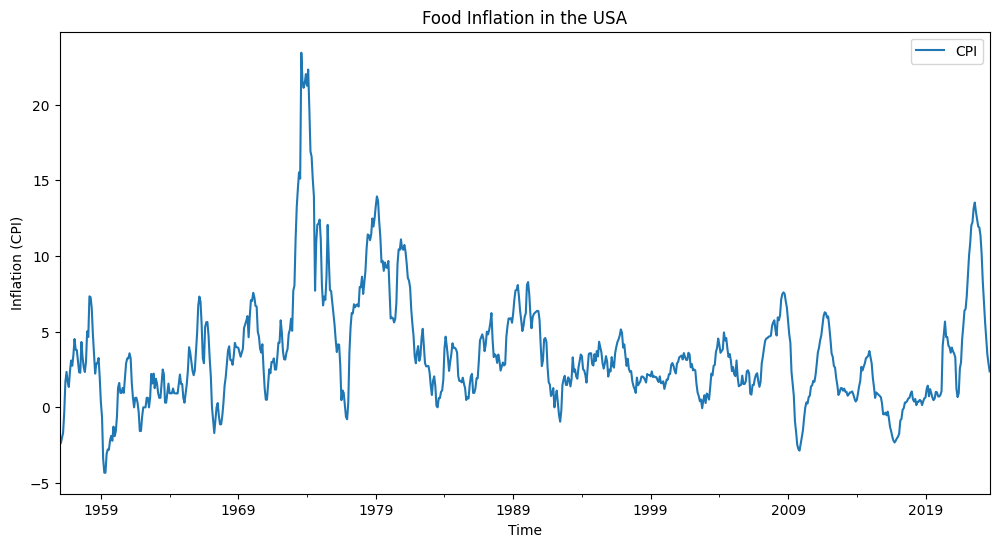

In [36]:
# plot the CPI data
cpi_timeseries.plot(figsize=(12, 6))

# add labels and title
plt.xlabel('Time')
plt.ylabel('Inflation (CPI)')
plt.title('Food Inflation in the USA')

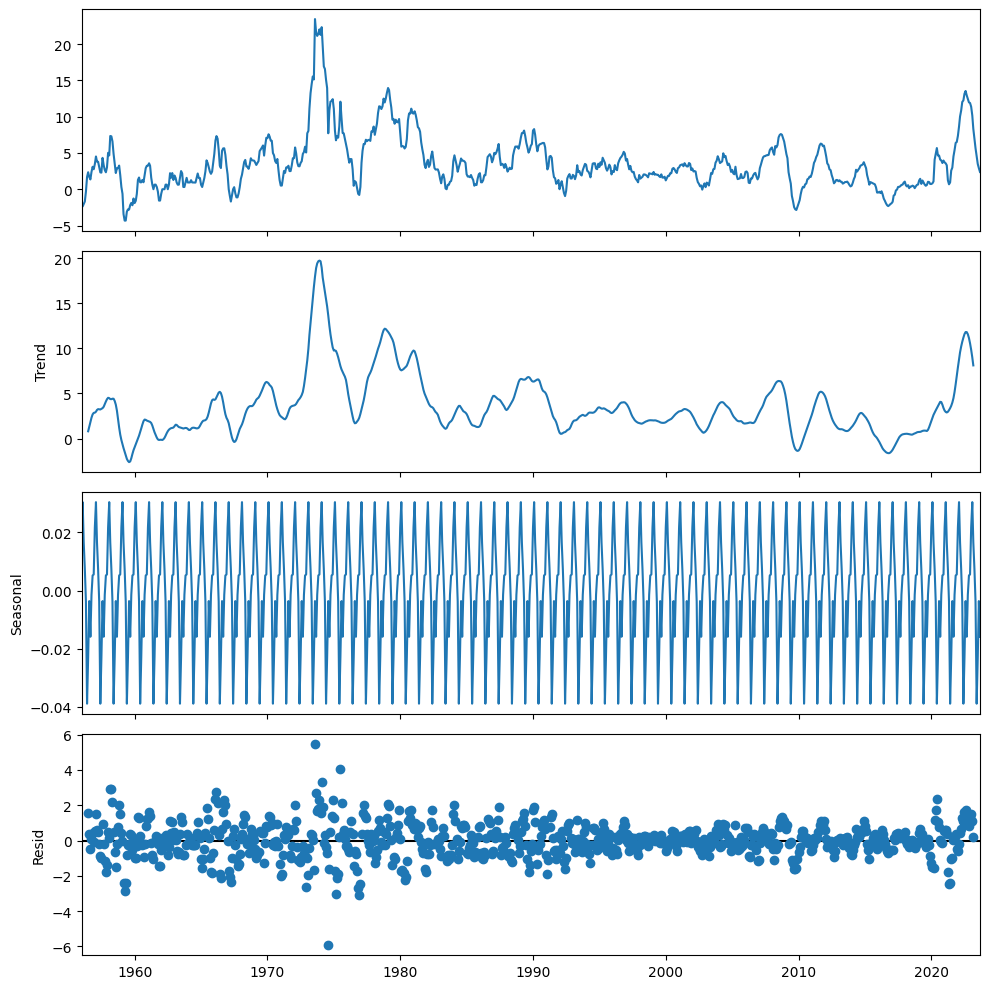

In [37]:
# decompose time series with additive model
decomposition = sm.tsa.seasonal_decompose(cpi_timeseries, model = 'additive', period=12)
plt.rcParams['figure.figsize'] = [10,10]
additive_decomp = decomposition.plot()
# get the trend, seasonal and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

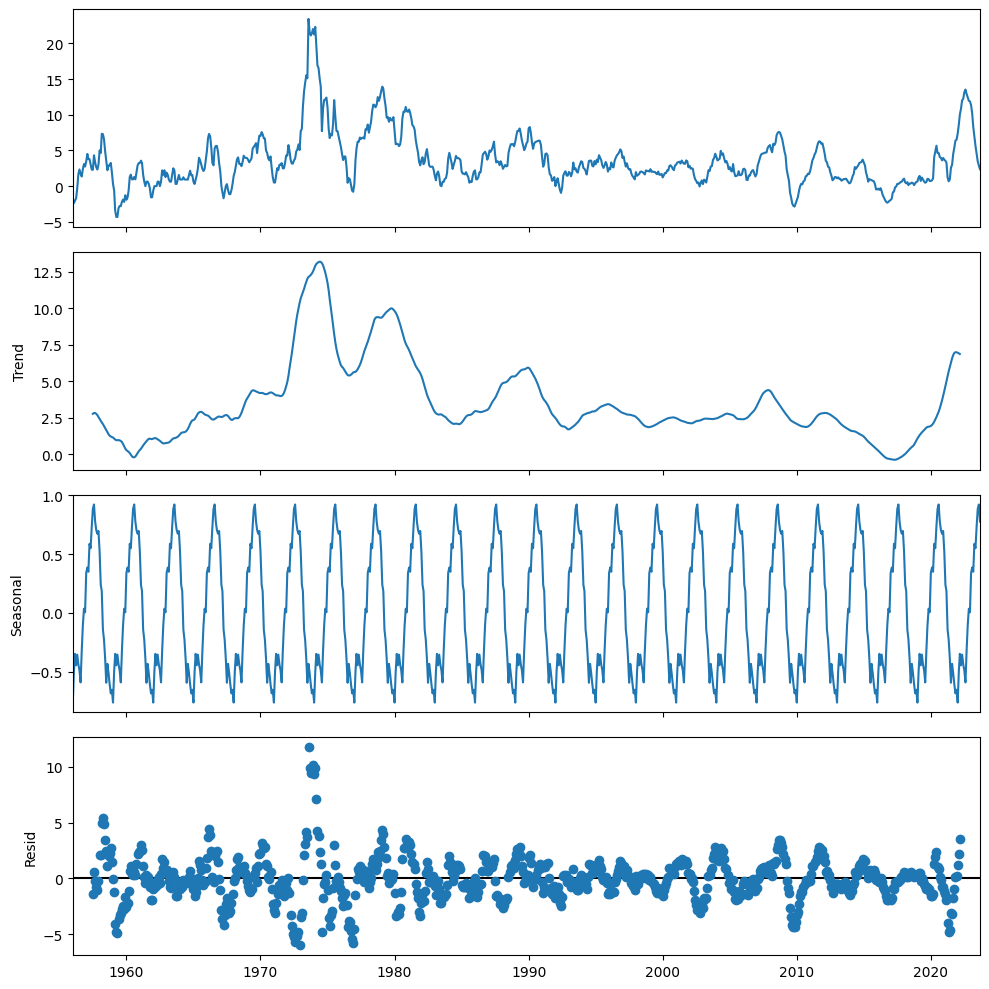

In [38]:
# decompose time series with multiplicative model
decomposition = sm.tsa.seasonal_decompose(cpi_timeseries, model = 'additive', period=36)
plt.rcParams['figure.figsize'] = [10,10]
additive_decomp = decomposition.plot()
# get the trend, seasonal and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [39]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(cpi_timeseries)

##################### Shape #####################
(813, 1)
##################### Types #####################
CPI    float64
dtype: object
##################### Head #####################
                 CPI
Date                
1956-01-01 -1.700680
1956-02-01 -2.372881
1956-03-01 -2.033898
##################### Tail #####################
                 CPI
Date                
2023-07-01  3.485868
2023-08-01  2.893452
2023-09-01  2.376901
##################### NA #####################
CPI    0
dtype: int64
##################### Quantiles #####################
         0.00      0.05      0.50      0.95      0.99      1.00
CPI -4.320988 -0.854221  2.841918  11.09003  16.86858  23.43387


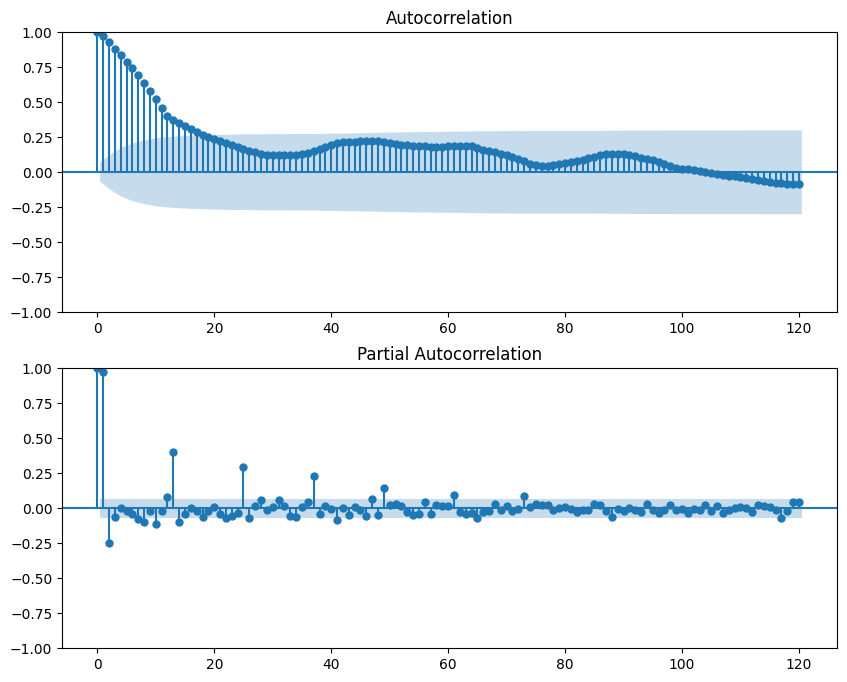

In [40]:
# plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(cpi_timeseries, lags=120, ax=ax[0])
sm.graphics.tsa.plot_pacf(cpi_timeseries, lags=120, ax=ax[1])
plt.show()


           CPI
Date          
1990  6.536602
1991  2.674094


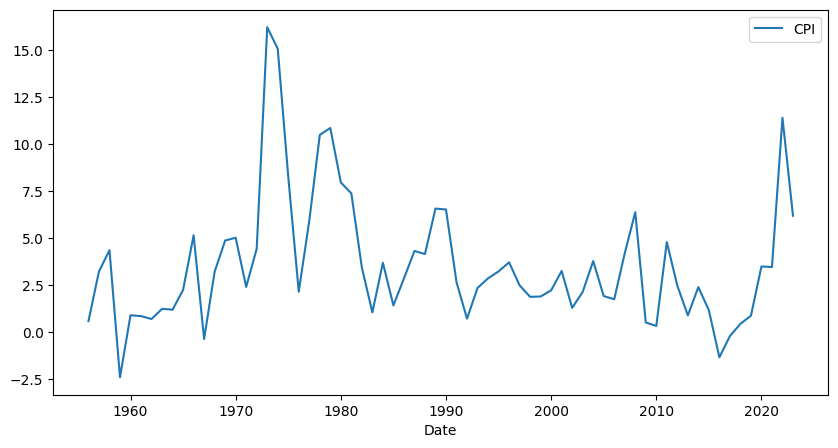

In [42]:
# group the cpi data by year and plot the mean for each year
yearly_cpi = cpi_timeseries.groupby(cpi_timeseries.index.year).mean()
yearly_cpi.plot(figsize=(10, 5))

# create new dataframe with yearly inflation
yearly_cpi = pd.DataFrame(yearly_cpi['CPI'])
# get only the years from 1990 to 2021
yearly_cpi = yearly_cpi.loc[1990:2021]
print(yearly_cpi.head(2))
